In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import pprint

In [2]:
df = pd.read_pickle("./data.pkl") 
print(df.shape)

(1024, 13)


#### 13 columns: 1st column is time (independent var.), 2nd column is uncertainty (in m/s), col 3-13 are datasets (units m/s)

## Q1. Fit to sinusoidal function of type <font color='blue'>$A_1 cos(2\pi t/T_0) + A_2 sin(2\pi t/T_0) + B$</font>

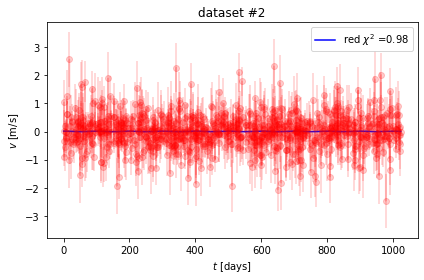

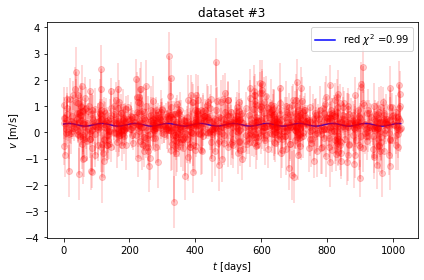

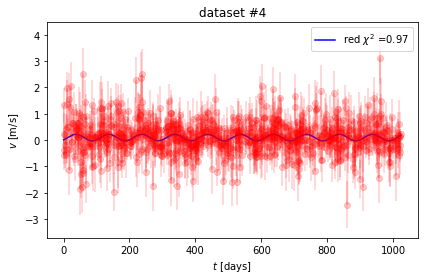

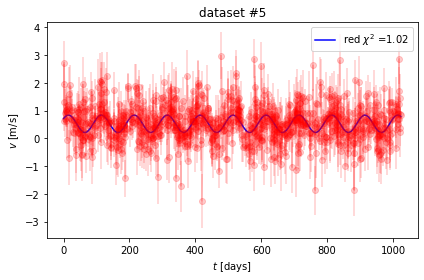

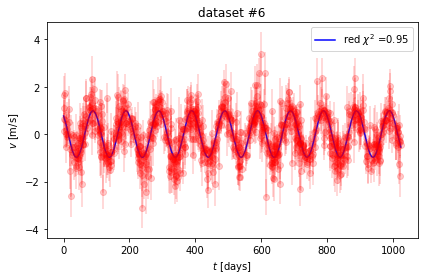

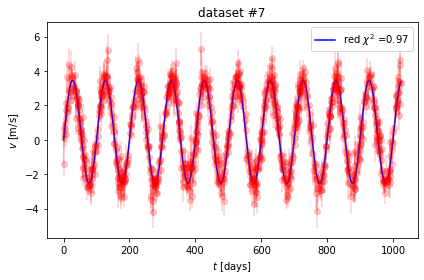

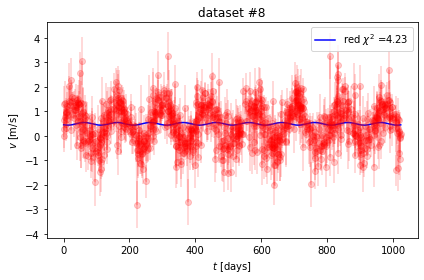

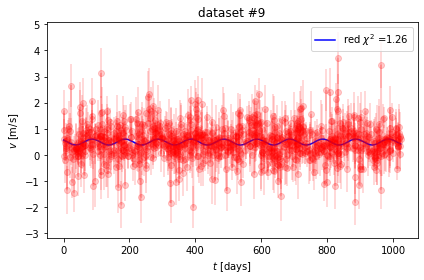

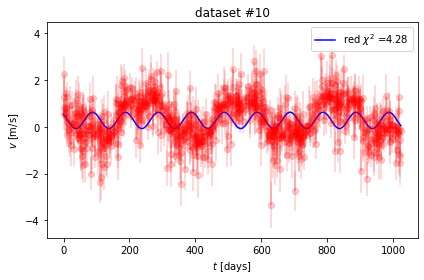

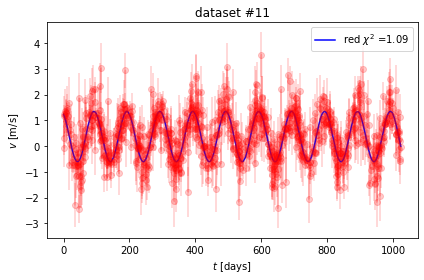

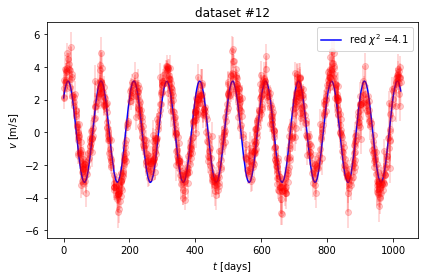

In [4]:
LL_dict = {} #save log likelihoods in here

#plot dataset
for i in range(2,13):
    
    X_data = df[:,0]
    Y_data_err = df[:,1]
    Y_data = df[:,i]
    
    fig, ax = plt.subplots()
    ax.errorbar(X_data,Y_data,yerr = Y_data_err, marker = 'o', c = 'red', alpha = 0.2)
    ax.set_title('dataset #{}'.format(i))
    
    #minimize chi_sq. Remember chi_sq is -2*LL
    #I know there are more efficient ways to do rather than having the function in the for loop, but I did that
        #because minimize function takes in the model, and parameters as next argument. Not sure how to re-write
        #with info and data.
    T0 = 100
    def chi_sq(params):
        A1, A2, B = params[0], params[1], params[2]
        y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B\
                for i in range(len(X_data))]
        func_list = [(Y_data[i]-y_fit[i])**2/Y_data_err[i]**2 for i in range(len(X_data))]
        ans = np.sum(func_list)
        return ans
              
    LL_model = minimize(chi_sq, np.array([1,1,1]), method = 'SLSQP')
    A1, A2, B = LL_model.x[0], LL_model.x[1], LL_model.x[2]
    
    #save information to dictionary:
    LL_dict[i] = [(A1, A2, B), chi_sq([A1, A2, B])/(len(X_data) -1), -1/2*chi_sq([A1, A2, B])]
    
    y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B\
                for i in range(len(X_data))]
    ax.plot(X_data, y_fit, 'b-', label = r'red $\chi^2$ ={}'.format(round((chi_sq([A1, A2, B])/(len(X_data) -1)),2)))

    ax.set_xlabel(r'$t$ [days]')
    ax.set_ylabel(r'$v$ [m/s]')
    ax.legend()

    plt.tight_layout()

In [142]:
#print all information from model
print('dictionary of form: (A1,A2,B), reduced chisq, log-likelihood')
pprint.pprint(LL_dict)

dictionary of form: (A1,A2,B), reduced chisq, log-likelihood
{2: [(0.008959334214890743, -0.0009323547832740114, 0.005081535433127837),
     0.984796734883392,
     -503.723529892855],
 3: [(0.02680687148045588, 0.04253461007891845, 0.28640313143698626),
     0.9907375519314918,
     -506.76225781295807],
 4: [(-0.08662208320865802, 0.08813394277399819, 0.09560586793888103),
     0.9728611243678439,
     -497.6184651141522],
 5: [(0.18853248915518436, 0.24983257710342047, 0.5235855196182729),
     1.0165350124732622,
     -519.9576588800736],
 6: [(0.7622605986833332, -0.6185043767722943, 0.007465128325722992),
     0.9486133793410675,
     -485.215743532956],
 7: [(-0.46008998355687575, 2.9716239870720047, 0.4600945203091629),
     0.9656882858161775,
     -493.94955819497477],
 8: [(-0.03818782538778033, -0.03799637145453419, 0.4927122391897828),
     4.2294206763342626,
     -2163.348675944975],
 9: [(0.07607086692610418, -0.0824442878530491, 0.4908278763405765),
     1.255833194190

## Q2. Fit to sinusoidal function of type <font color='blue'>$ A_1 cos(2\pi t/T_0) + A_2 sin(2\pi t/T_0) + A_3 cos(2\pi t/T_1) + A_4 sin(2\pi t/T_1) + B$ </font>

5.0


Text(0, 0.5, 'Log-Likelihood')

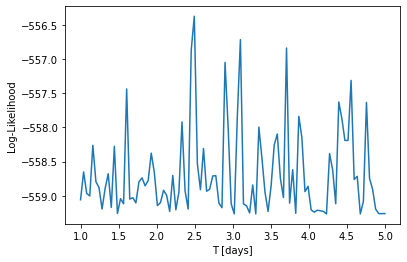

In [9]:
#Fitting in this manner would not work well. So let's do brute force.
#we profile out the nuisance by calculating likelihood at different values of T_1, where T_1 in [0,200]
T_list = np.linspace(1,5,100)
#try it on first dataset.
X_data = df[:,0]
Y_data_err = df[:,1]
Y_data = df[:,11]

likelihood = []
for T1 in T_list:
    if T1%5 == 0:
        print(T1)
    #calc. chi_sq
    def chi_sq(params):
        A1, A2, B = 0.8646567313455039, -0.4572732376093302, 0.3724281382842254
        A3, A4 = params[0], params[1]
        y_fit = [A1*np.cos(2*np.pi*X_data[i]/T0) + A2*np.sin(2*np.pi*X_data[i]/T0) + B + \
                 A3*np.cos(2*np.pi*X_data[i]/T1) + A4*np.cos(2*np.pi*X_data[i]/T1) \
                 for i in range(len(X_data))]
        func_list = [(Y_data[i]-y_fit[i])**2/Y_data_err[i]**2 for i in range(len(X_data))]
        ans = np.sum(func_list)
        return ans
    LL_model = minimize(chi_sq, np.array([1,1]), method = 'SLSQP')
    A3, A4 = LL_model.x[0], LL_model.x[1]
    likelihood.append(-1/2*chi_sq([A3, A4]))

fig, ax = plt.subplots()
ax.plot(T_list, likelihood)
ax.set_xlabel('T [days]')
ax.set_ylabel('Log-Likelihood')